In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os
from pyspark.sql import SparkSession 

In [2]:
# Data Preprocessing

In [3]:

spark = SparkSession.builder.appName('Recommender_system').getOrCreate()

In [4]:
data = spark.read.csv('C:/Users/Nusu Queen/Desktop/Data Science Project/TopperWorld/Movie Recommend System/Dataset/ratings.csv", 
header=True, inferSchema=True)
data.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



In [5]:
num_rows = data.count()

# Count the number of columns
num_columns = len(data.columns)

# Print the shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 25000095
Number of columns: 4


In [6]:
# Read data from CSV file
movie_names_data = spark.read.csv("C:/Users/Mostafijur Rahman/Desktop/My Project/Data Science Project/TopperWorld/Movie Recommend System/Dataset/movies.csv", header=True, inferSchema=True)
movie_names_data.show()

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
|      6|         Heat (1995)|Action|Crime|Thri...|
|      7|      Sabrina (1995)|      Comedy|Romance|
|      8| Tom and Huck (1995)|  Adventure|Children|
|      9| Sudden Death (1995)|              Action|
|     10|    GoldenEye (1995)|Action|Adventure|...|
|     11|American Presiden...|Comedy|Drama|Romance|
|     12|Dracula: Dead and...|       Comedy|Horror|
|     13|        Balto (1995)|Adventure|Animati...|
|     14|        Nixon (1995)|               Drama|
|     15|Cutthroat Island ...|Action|Adventure|...|
|     16|       Casino (1995)|         Crime|Drama|
|     17|Sen

In [7]:

data.printSchema()


root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [8]:
data.describe().show()

+-------+-----------------+------------------+------------------+--------------------+
|summary|           userId|           movieId|            rating|           timestamp|
+-------+-----------------+------------------+------------------+--------------------+
|  count|         25000095|          25000095|          25000095|            25000095|
|   mean|81189.28115381162|21387.981943268616| 3.533854451353085|1.2156014431215513E9|
| stddev|46791.71589745776| 39198.86210105973|1.0607439611423535| 2.268758080595386E8|
|    min|                1|                 1|               0.5|           789652009|
|    max|           162541|            209171|               5.0|          1574327703|
+-------+-----------------+------------------+------------------+--------------------+



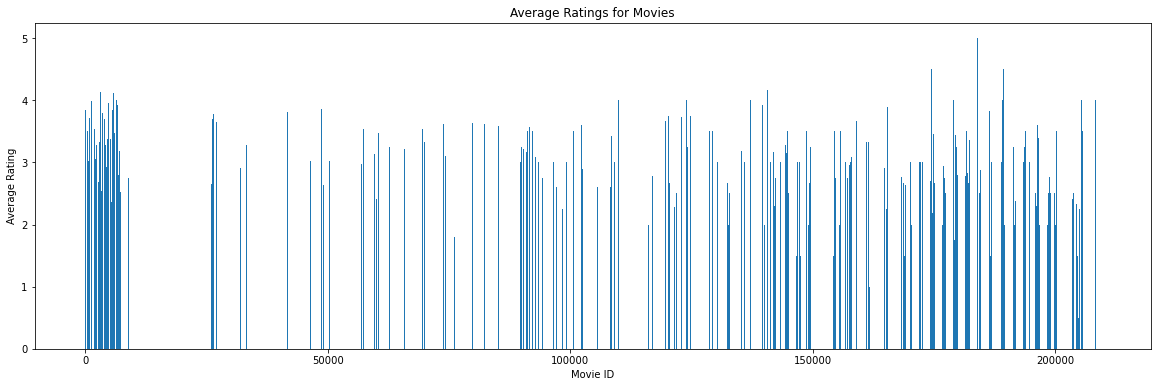

In [10]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg  

# Calculate average ratings for each movie
avg_ratings = data.groupBy("movieId").agg(avg("rating").alias("avg_rating"))

# Join the average ratings with movie names based on the movieId column
combined_data = avg_ratings.join(movie_names_data, on="movieId")

# Convert the PySpark DataFrame to a Pandas DataFrame for plotting
combined_data_pd = combined_data.toPandas()

# Create a bar plot
plt.figure(figsize=(20, 6))
plt.bar(combined_data_pd["movieId"], combined_data_pd["avg_rating"])
plt.xlabel("Movie ID")
plt.ylabel("Average Rating")
plt.title("Average Ratings for Movies")
plt.show()


In [11]:

train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)

# Show the number of rows in the training and testing sets
print("Number of rows in train_data:", train_data.count())
print("Number of rows in test_data:", test_data.count())

Number of rows in train_data: 19997916
Number of rows in test_data: 5002179


In [12]:
# Modelling

In [13]:
from pyspark.ml.recommendation import ALS    

# Build the recommendation model using ALS on the training data
als = ALS(maxIter=15, regParam=0.01, userCol="userId" ,itemCol="movieId", ratingCol="rating")
#Fit the Model on Item-Based Data
model = als.fit(train_data)

In [14]:
# Evaluation

In [15]:
# Make predictions on the test data using the trained model
predictions = model.transform(test_data)

# Show the predictions, including original columns and the "prediction" column
predictions.show()


+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|     1|    307|   5.0|1147868828| 3.7200267|
|     1|   1175|   3.5|1147868826| 4.4520154|
|     1|   2011|   2.5|1147868079|  2.047362|
|     1|   2012|   2.5|1147868068| 1.5757331|
|     1|   2632|   5.0|1147878248| 3.0135047|
|     1|   3949|   5.0|1147868678| 4.4476156|
|     1|   4973|   4.5|1147869080| 4.6071777|
|     1|   5147|   4.0|1147877654| 3.7495253|
|     1|   5767|   5.0|1147878729| 3.9949007|
|     1|   5878|   4.0|1147868807|  4.154049|
|     1|   5912|   3.0|1147878698|  2.910003|
|     1|   6370|   4.5|1147869191| 4.5123396|
|     1|   6539|   3.5|1147868461| 3.7913249|
|     1|   7327|   3.5|1147868855| 3.9197721|
|     1|   8014|   3.5|1147869155|  3.693029|
|     1|   8729|   3.5|1147878452|  4.412877|
| 32906|   1196|   5.0| 965798810| 4.4921994|
| 32906|   1209|   5.0| 965799052| 4.6548004|
| 32906|   1231|   5.0| 965802182|

In [16]:
# Drop rows where the "prediction" column has missing values (nulls)
predictions_no_missing = predictions.na.drop(subset=["prediction"])


In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

# Create a RegressionEvaluator instance with the specified metricName and columns
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Compute the RMSE on the predictions using the RegressionEvaluator
rmse = evaluator.evaluate(predictions_no_missing)

# Print the calculated RMSE
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 0.8003023306872628


In [18]:
single_user = test_data.filter(test_data['userId']==12).select(['movieId','userId'])
# User had 10 ratings in the test data set 
# Realistically this should be some sort of hold out set!
single_user.show()

+-------+------+
|movieId|userId|
+-------+------+
|     21|    12|
|     32|    12|
|     36|    12|
|     48|    12|
|     54|    12|
|     97|    12|
|    141|    12|
|    150|    12|
|    231|    12|
|    261|    12|
|    317|    12|
|    329|    12|
|    344|    12|
|    433|    12|
|    435|    12|
|    505|    12|
|    516|    12|
|    531|    12|
|    546|    12|
|    555|    12|
+-------+------+
only showing top 20 rows



In [19]:
reccomendations = model.transform(single_user)
reccomendations.orderBy('prediction',ascending=False).show()

+-------+------+----------+
|movieId|userId|prediction|
+-------+------+----------+
|   1221|    12| 4.4401164|
|   4973|    12| 4.3941245|
|    750|    12|  4.372083|
|   1288|    12|  4.269582|
|    745|    12| 4.2476654|
|   3435|    12|  4.217212|
|   2804|    12| 4.2119513|
|   1212|    12| 4.2084613|
|    910|    12| 4.1932387|
|   1267|    12|  4.190216|
|  48394|    12|  4.182474|
|   1089|    12| 4.1523533|
|  55820|    12|  4.129227|
|  30749|    12|  4.099454|
|   1449|    12|  4.084496|
|   1222|    12|  4.065552|
|   5669|    12| 4.0631456|
|   4027|    12| 4.0559983|
|   1243|    12|  4.045491|
|   1079|    12| 4.0415416|
+-------+------+----------+
only showing top 20 rows

